In [1]:
#Initiate libraries needed for script

import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import matplotlib.cm as cm
from numpy import linspace
import copy
import statistics
import pandas as pd
from scipy.stats import linregress

#functions used in this script:


#opening directory and grabbing all text files with wildcard
#in this case it is all with DMPC_LUV in the name
#function to pull all files (X and Y coordinates) for text files with wildcard matching input
def filepull(a,p):
    files = []
    for file in sorted(glob.glob(a)):
        files.append(file)

    fx = []
    fy = []
    
    #For each text file in the directory, opening it and grabbing the plotting data within the file
    for fn in files:
        temp_x, temp_y = np.loadtxt(fn, unpack = True, skiprows = 54)
        fy.append(temp_y)
        fx.append(temp_x)
    #print(files)
    #putting into unique array for calling later on to plot
    y = np.asarray(fy)
    x = np.asarray(fx)
    if p == 1:
        print(files)
    return x,y

#Used to remove the initial 5 minute incubation time (i.e. start at injection point which is fluorescence minima)
def trim(x,y):
    i = 0
    new_x = []
    new_y = []
    lowest = max(y)
    while i < len(y):
        if lowest > y[i]:
            lowest = y[i]
            new_0 = i 
        i = i+1
        
    i = new_0
    while i < len(x):
        new_x.append(x[i]-x[new_0])
        new_y.append(y[i])
        i = i+1
    return new_x, new_y

#Average the three spectra and return average with errors (and in minutes, not seconds)
def AVG(y1, y2, y3):
    #Average
    i = 0
    new = []
    time = []
    while i < len(y1):
        temp = (y1[i]+y2[i]+y3[i])
        temp = (temp/3)
        new.append(temp)
        time.append(i/600)
        i = i+1
    pe, me  = stderr(y1, y2, y3, new) 
    return time, new, pe, me

#Find the maximal and minimal values for the array
def minmax(arr):
    i = 0
    min_temp = []
    max_temp = []
    while i < len(arr):
        min_temp.append(min(arr[i]))
        max_temp.append(max(arr[i]))
        i= i+1
        
    return min_temp, max_temp


def minmaxavg(arr):
    i = 0
    min_temp = []
    max_temp = []
    while i < len(arr):
        min_temp.append(min(arr[i]))
        max_temp.append(max(arr[i]))
        i= i+1
        
    min_temp = statistics.mean(min_temp)
    max_temp = mean(max_temp)
    return min_temp, max_temp

#calculate the standard error of the spectra, and put this error on the average for plotting
def stderr(y1, y2, y3, y_avg):
    i = 0 
    temp_arr = []
    error = []
    while i < len (y1):
        temp_arr.append([y1[i],y2[i],y3[i]])
        error.append(statistics.stdev(temp_arr[i]))
        i = i+1

    i = 0
    minus_error = []
    plus_error = []
    while i < len(error):
        minus_error.append((y_avg[i] - error[i]))
        plus_error.append((y_avg[i] + error[i]))
        i = i+1
    return plus_error, minus_error


#This converts the fluoresence (in AU) to actual NBD-PE concentration according to a standard titration curve (in folder)
def axis_correct(y):
    i = 0
    #figures gathered from excel spreadsheet (in same folder), 
    #trendline of scatterplot between TR-FRET y axis and 'normal' fluorimetry figures
    intercept = 85.03
    gradient = 1.0057
    while i < len(y):
        j = 0
        while j < len(y[i]):
            temp = y[i][j]
            temp = (temp+intercept)*gradient
            y[i][j] = temp
            j = j+1
        i = i+1
        
    return y

#Calculate the rate of initial fluoresence recovery from injection point (the rate of mixing)
def rate_finder(x, y, val):
    tempy = []
    tempx = []
    tempy.append(y[5])#The [5] here ensures that it the recording is after the spectra ha settled
    tempy.append(y[5+val]) #This is the range to measure between, where val is chosen depending on the straight line plot
    #i.e. where the recovery is still linearly increasing, and not curving
    
    tempx.append(x[5]) #Doe the same to get the x and y values of this for the gradient calculation
    tempx.append(x[5+val])
    
    #calculate gradient - as this is in NBD-PE concentration, the gradient is the rate of recovery (and therefore mixing)
    temp1 = (tempy[1]-tempy[0])
    temp2 = (tempx[1]-tempx[0])
    gradient = temp1/temp2
    
    return gradient

#Three spectra, needs three different rate calculations
def rate_finder_multiple(x1, x2, x3, y1, y2, y3, cut):
    grad1 = rate_finder(x1, y1, cut)
    grad2 = rate_finder(x2, y2, cut)
    grad3 = rate_finder(x3, y3, cut)
    
    #Once all three are calculated, they are averaged and error-ed
    rate = ((grad1+grad2+grad3)/3)
    rate_err = statistics.stdev([grad1, grad2, grad3])
    
    return rate, rate_err


#Standard colours used within the thesis
colors = [sns.xkcd_rgb["black"], #0, black
          sns.xkcd_rgb["cerulean"], #1 blue
          sns.xkcd_rgb["moss green"], #2 dark green
          sns.xkcd_rgb["rust"], #3 dark red
          sns.xkcd_rgb["slate"], #4 slate/grey-blue
          sns.xkcd_rgb["mustard"], #5 yellow
          sns.xkcd_rgb["tangerine"], # 6 tangerine ***** this is for SMA 3:1
          sns.xkcd_rgb["coral"], #7 pink-red ***** This is for SMA 2:1
          sns.xkcd_rgb["grass"], #8 grass (brighter green)***** This is for DIBMA
          sns.xkcd_rgb["bright blue"], #9  royal blue *****This is for PMA
          sns.xkcd_rgb["olive green"], #10 olive green
          sns.xkcd_rgb["goldenrod"], #11 For NBD-PE
          sns.xkcd_rgb["rose"] #12 For Rhodamine-PE
         ]

#standard plotting style used within this thesis.
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [10]:
#read in the files
SECx, SECy_ = filepull("SEC*.txt",1)
noSECx, noSECy_ = filepull("noSEC*.txt",1)


#Correct y axes from AU to actual concnetration of NBD-Pe (or other dye used)
SECy = axis_correct(SECy_)
noSECy = axis_correct(noSECy_)

#this takes a while as it is over 21000 points per spectra,
#so the print() is to make sure it is running/ tells when it is done
print("Done import!")

#Average the triplicates for plotting, with associated errors
SEC_time, SEC_avg, SECpe, SECme = AVG(SECy[0], SECy[1], SECy[2])
noSEC_time, noSEC_avg, noSECpe, noSECme = AVG(noSECy[0], noSECy[1], noSECy[2])
print("Done")

['SEC_1.txt', 'SEC_2.txt', 'SEC_3.txt']
21001 21001 21001
['noSEC_1.txt', 'noSEC_2.txt', 'noSEC_3.txt']
21001 21001 21001
Done import!
Done


In [13]:
#Calculate the rate of mixing (from the initial recovery rate after injection)


#trim to lowest initial point (for rate calculation)
#lowest point is the injection point of the sample, so a handy identifier

#Needs to be done for each triplicate for rate calculation
#SEC
tSECx1, tSECy1 = trim(SECx[0], SECy[0])
tSECx2, tSECy2 = trim(SECx[1], SECy[1])
tSECx3, tSECy3 = trim(SECx[2], SECy[2])
SEC_rate, SEC_rate_err = rate_finder_multiple(tSECx1, tSECx2, tSECx3,
                                             tSECy1, tSECy2, tSECy3, 200)
#the 200 value here is the number of 0.1s increments to measure the gradient between, before the line curves
#this was selected manually by eye

#noSEC
tnoSECx1, tnoSECy1 = trim(noSECx[0], noSECy[0])
tnoSECx2, tnoSECy2 = trim(noSECx[1], noSECy[1])
tnoSECx3, tnoSECy3 = trim(noSECx[2], noSECy[2])
noSEC_rate, noSEC_rate_err = rate_finder_multiple(tnoSECx1, tnoSECx2, tnoSECx3,
                                             tnoSECy1, tnoSECy2, tnoSECy3, 200)


In [4]:
#Time for plotting!
# Well, sort of - this is for the plotting of the straight line plot ontop of the recovery curve
# It is purely cosmetic for the thesis, so feel free to ignore this bit

#find the lowest point on the spectra (to start the line)
min_SEC = np.min(SEC_avg)
min_SEC_loc = np.where(SEC_avg == min_SEC)
#correcting for np.min() and np.where() to be slightly off for some reason...

#find the (x,y) point used to detect the recovery gradient (i.e. +200 from minima)
max_SEC_loc = SEC_time[min_SEC_loc[0][0]+205]
min_SEC_loc = SEC_time[min_SEC_loc[0][0]+5]

#Extending line for initial gradient - purely cosmetic as otherwise it's very short
SEC_loc_a = min_SEC
SEC_loc_b = (tSECy1[205]+tSECy2[205]+tSECy3[205])/3
SEC_loc_y = [SEC_loc_a, SEC_loc_b]
SEC_loc_x = [min_SEC_loc, max_SEC_loc]
grad = linregress(SEC_loc_x, SEC_loc_y)

#y = mx+c
temp_y = 250 # This extens it a bit further than 200
temp_x = ((temp_y-grad[1])/grad[0])

SEC_loc_y.append(temp_y)
SEC_loc_x.append(temp_x)

#Does the same for the no SEC sample also
min_noSEC = np.min(noSEC_avg)
min_noSEC_loc = np.where(noSEC_avg == min_noSEC)
#correcting for np.min() and np.where() to be slightly off for some reason...
max_noSEC_loc = noSEC_time[min_noSEC_loc[0][0]+205]
min_noSEC_loc = noSEC_time[min_noSEC_loc[0][0]+5]
#Extending line for initial gradient
noSEC_loc_a = min_noSEC
noSEC_loc_b = (tnoSECy1[205]+tnoSECy2[205]+tnoSECy3[205])/3
noSEC_loc_y = [noSEC_loc_a, noSEC_loc_b]
noSEC_loc_x = [min_noSEC_loc, max_noSEC_loc]
grad = linregress(noSEC_loc_x, noSEC_loc_y)
#y = mx+c
temp_y = 290
#print(temp_y)
temp_x = ((temp_y-grad[1])/grad[0])
#print(temp_y)
noSEC_loc_y.append(temp_y)
noSEC_loc_x.append(temp_x)

Done


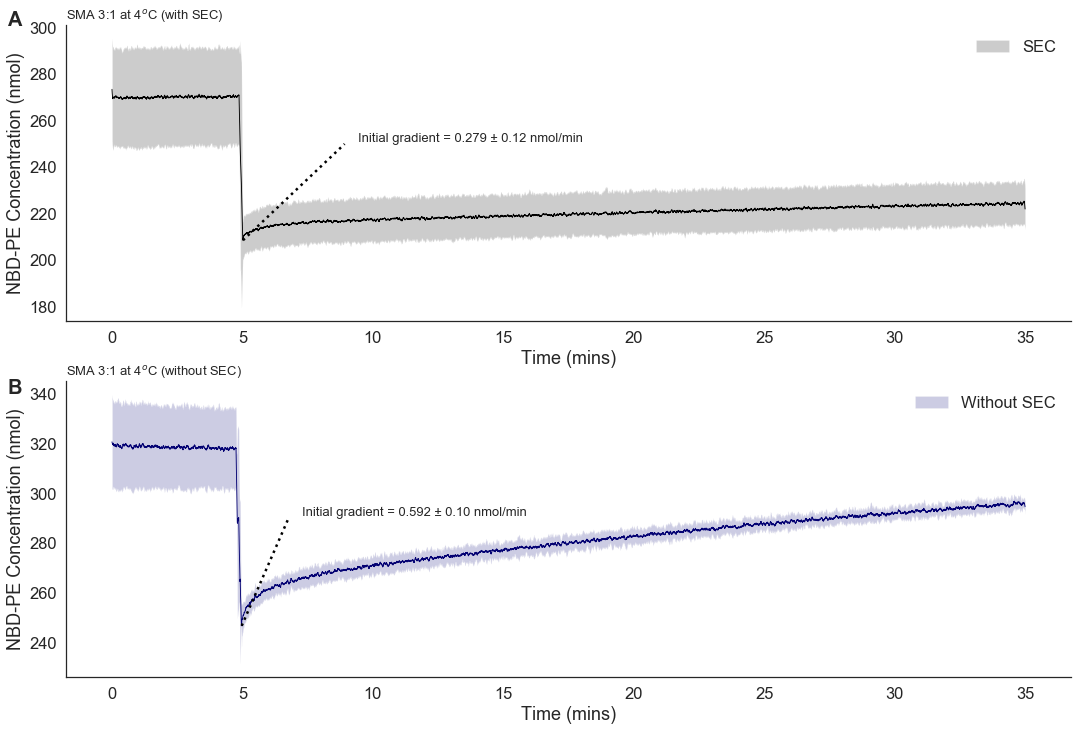

In [7]:
#Ok, NOW we can plot!
#Two plots, on top of each other
fig, axs = plt.subplots(2, 1, figsize=(18, 12), frameon = True)
axs[0].set_title("SMA 3:1 at 4$^{o}$C (with SEC)", fontsize = 13, loc = 'left')
#Setting colour through the color[i] custom colour list
i = 0
#axs[0] is the SEC plot, you need two plots for the spectra
#these plot the line (for the average spectra) and then the filled in region to show the +/- error
axs[0].plot(SEC_time, SEC_avg, color = colors[i], lw = 0.9)
axs[0].fill_between(SEC_time, SECme, SECpe, alpha=0.2, facecolor=colors[i], label = "SEC")

#this just plots the straight line for the initial gradient, and then labels the gradient and therefore rate
axs[0].plot(SEC_loc_x, SEC_loc_y, color = colors[0], ls = ":")
axs[0].text(x = SEC_loc_x[-1]+.5, y = 251,
            s = "Initial gradient = {:.3f} ± {:.2f} nmol/min".format(SEC_rate, SEC_rate_err),fontsize = 13)

#moving on to the no SEc, second plot
i = 11
axs[1].set_title("SMA 3:1 at 4$^{o}$C (without SEC)", fontsize = 13, loc = 'left')
axs[1].plot(noSEC_time, noSEC_avg, color = colors[i], lw = 0.9)
axs[1].fill_between(noSEC_time, noSECme, noSECpe, alpha=0.2, facecolor=colors[i], label = "Without SEC")
axs[1].plot(noSEC_loc_x, noSEC_loc_y, color = colors[0], ls = ":")
axs[1].text(x = noSEC_loc_x[-1]+.5, y = 291,
            s = "Initial gradient = {:.3f} ± {:.2f} nmol/min".format(noSEC_rate, noSEC_rate_err),fontsize = 13)

#Putting legends, axes labels and titles on each plot
axs[0].legend(frameon = False, loc = "upper right")
axs[0].set_xlabel("Time (mins)")
axs[0].set_ylabel("NBD-PE Concentration (nmol)")

axs[1].legend(frameon = False, loc = "upper right")
axs[1].set_xlabel("Time (mins)")
axs[1].set_ylabel("NBD-PE Concentration (nmol)")

#Labelling for thesis reference
axs[0].text(x = -4, y = 1.1*max(SEC_avg), s = "A", fontsize = 20, weight= "bold")
axs[1].text(x = -4, y = 1.06*max(noSEC_avg), s = "B", fontsize = 20, weight= "bold")
sns.despine()
#plt.savefig('SECvsNoSEC_Standard.png', format='png',dpi=300, bbox_inches="tight")
plt.show()